# Master Equation Solver: Vacuum Rabi oscillations

Authors: J.R. Johansson and P.D. Nation

Slight modifications: C. Staufenbiel (2022)

This notebook demonstrates how to simulate the quantum vacuum rabi 
oscillations in the Jaynes-Cumming model, using the Master Equation Solver 
`qutip.mesolve`. We also consider the dissipative version of the 
Jaynes-Cumming model, i.e., the cavity and the atom are coupled to an 
environment.

For more information on the theory behind the Master Equation Solver see [the documentation](https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html#non-unitary-evolution).

### Package import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import about, basis, destroy, mesolve, qeye, sigmaz, tensor

%matplotlib inline

# Introduction

The Jaynes-Cumming model is the simplest possible model of quantum mechanical light-matter interaction, describing a single two-level atom interacting with a single electromagnetic cavity mode. The Hamiltonian for this system is (in dipole interaction form)

$H = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger + a)(\sigma_- + \sigma_+)$

or with the rotating-wave approximation

$H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$

where $\omega_c$ and $\omega_a$ are the frequencies of the cavity and atom, respectively, and $g$ is the interaction strength.

In this example we also consider the coupling of the Jaynes-Cummings model to an external environment, i.e., we need to solve the system using the Master Equation Solver `qutip.mesolve`. The coupling to the environment is described by the collapse operators (as described in [the docs](https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html#non-unitary-evolution)). Here, we consider two collapse operators for the cavity $C_1, C_2$, describing creation and annihilation of photons, and one collapse operator for the atom $C_3$.

$C_1 = \sqrt{\kappa (1+\langle n \rangle)} \; a$

$C_2 = \sqrt{\kappa \langle n \rangle}\; a^\dagger$

$C_3 = \sqrt{\gamma} \; \sigma_-$

where $\langle n \rangle$ is the average number of photons in the environment. By setting $\langle n \rangle=0$ we remove the creation of photons and only consider the annihilation of photons.

### Problem parameters

Here we use units where $\hbar = 1$: 

In [2]:
N = 15  # number of cavity fock states
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
n_th_a = 0.0  # temperature in frequency units
use_rwa = True

tlist = np.linspace(0, 40, 100)

### Setup the operators, the Hamiltonian and initial state

Here we define the initial state and operators for the combined system, which consists of the cavity and the atom. We make use of the tensor product, where the first part refers to the cavity and the second part to the atom. We define the atom to be in the excited state and the cavity in its ground state.

The initial state  consists of the cavity ground state and the atom in the excited state. We define the collapse operator for the cavity/atom in the combined system and the Hamiltonian with and without the rotating-wave-approach.

In [3]:
# intial state
psi0 = tensor(basis(N, 0), basis(2, 0))

# collapse operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())
sz = tensor(qeye(N), sigmaz())

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + wa / 2 * sz + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * a.dag() * a + wa / 2 * sz + g * (a.dag() + a) * (sm + sm.dag())

### Create a list of collapse operators that describe the dissipation

We create a list of collapse operators `c_ops`, which is later passed on to `qutip.mesolve`. For each of the three processes one collapse operator is defined.

In [4]:
c_op_list = []

# Photon annihilation
rate = kappa * (1 + n_th_a)
c_op_list.append(np.sqrt(rate) * a)

# Photon creation
rate = kappa * n_th_a
c_op_list.append(np.sqrt(rate) * a.dag())

# Atom annihilation
rate = gamma
c_op_list.append(np.sqrt(rate) * sm)

### Evolve the system

Here we evolve the system with the Lindblad master equation solver `qutip.mesolve`, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_+\sigma_-$ are returned by the solver by passing the list `[a.dag()*a, sm.dag()*sm]` as the fifth argument to the solver.

In [5]:
output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a, sm.dag() * sm])

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00


20.2%. Run time:   0.01s. Est. time left: 00:00:00:00


30.3%. Run time:   0.01s. Est. time left: 00:00:00:00


40.4%. Run time:   0.01s. Est. time left: 00:00:00:00


50.5%. Run time:   0.02s. Est. time left: 00:00:00:00


60.6%. Run time:   0.02s. Est. time left: 00:00:00:00


70.7%. Run time:   0.02s. Est. time left: 00:00:00:00


80.8%. Run time:   0.03s. Est. time left: 00:00:00:00


90.9%. Run time:   0.03s. Est. time left: 00:00:00:00


100.0%. Run time:   0.03s. Est. time left: 00:00:00:00


Total run time:   0.03s


### Visualize the results

Here we plot the excitation probabilities of the cavity and the atom (these expectation values were calculated by the `mesolve` above). We can clearly see how energy is being coherently transferred back and forth between the cavity and the atom.

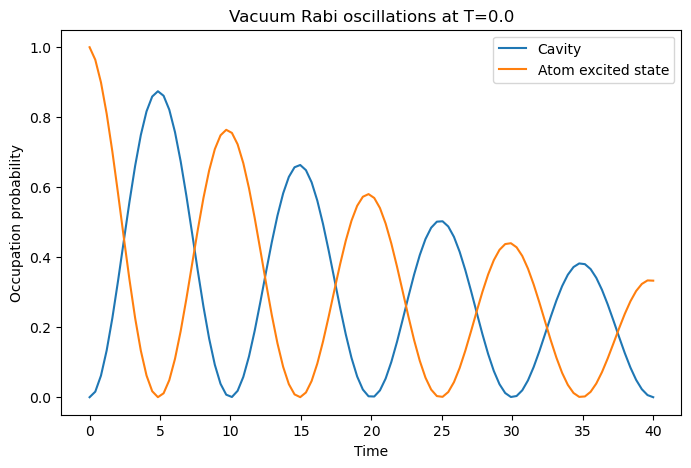

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, output.expect[0], label="Cavity")
ax.plot(tlist, output.expect[1], label="Atom excited state")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Vacuum Rabi oscillations at T={}".format(n_th_a));

### Non-zero temperature
Above we set $T = 0$ and thereby discarded the photon creation by the environment. We can activate this term by setting the corresponding variable to a positive value and perform the same calculation as above. In comparison to the previous plot, we see that the cavity has more energy than the atom.

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00


20.2%. Run time:   0.01s. Est. time left: 00:00:00:00


30.3%. Run time:   0.01s. Est. time left: 00:00:00:00


40.4%. Run time:   0.02s. Est. time left: 00:00:00:00


50.5%. Run time:   0.02s. Est. time left: 00:00:00:00


60.6%. Run time:   0.02s. Est. time left: 00:00:00:00

70.7%. Run time:   0.03s. Est. time left: 00:00:00:00


80.8%. Run time:   0.03s. Est. time left: 00:00:00:00


90.9%. Run time:   0.04s. Est. time left: 00:00:00:00

100.0%. Run time:   0.04s. Est. time left: 00:00:00:00


Total run time:   0.04s


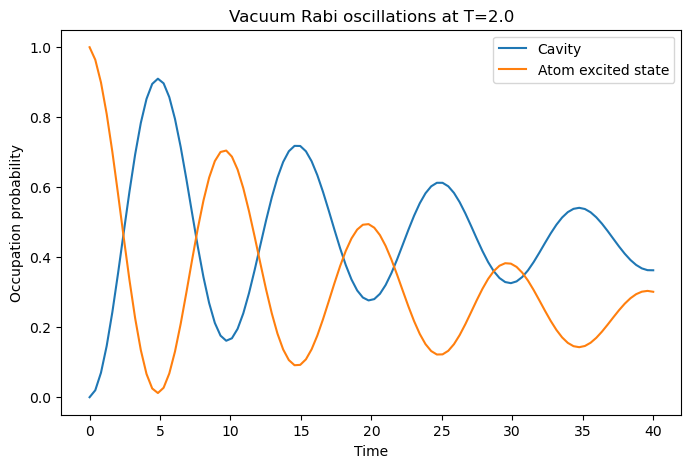

In [7]:
# set temperature
n_th_a = 2.0

# set collapse operators
c_op_list = []
rate = kappa * (1 + n_th_a)
c_op_list.append(np.sqrt(rate) * a)
rate = kappa * n_th_a
c_op_list.append(np.sqrt(rate) * a.dag())
rate = gamma
c_op_list.append(np.sqrt(rate) * sm)

# evolve system
output_temp = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a, sm.dag() * sm])

# plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, output_temp.expect[0], label="Cavity")
ax.plot(tlist, output_temp.expect[1], label="Atom excited state")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Vacuum Rabi oscillations at T={}".format(n_th_a));

### Software version:

In [8]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.0.dev0+afd160b
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.33
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `

### Testing

In [9]:
# sum of atom and cavity
atom_and_cavity = np.array(output.expect[0]) + np.array(output.expect[1])
assert np.all(np.diff(atom_and_cavity) <= 0.0)

# frequency for analytical solution (with RWA)
output_no_cops = mesolve(H, psi0, tlist, [], [a.dag() * a, sm.dag() * sm])
freq = 1 / 4 * np.sqrt(g**2 * (N + 1))
assert np.allclose(output_no_cops.expect[1],
                   (np.cos(tlist * freq)) ** 2, atol=10**-3)

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00


20.2%. Run time:   0.00s. Est. time left: 00:00:00:00


30.3%. Run time:   0.00s. Est. time left: 00:00:00:00


40.4%. Run time:   0.01s. Est. time left: 00:00:00:00


50.5%. Run time:   0.01s. Est. time left: 00:00:00:00


60.6%. Run time:   0.01s. Est. time left: 00:00:00:00


70.7%. Run time:   0.01s. Est. time left: 00:00:00:00


80.8%. Run time:   0.01s. Est. time left: 00:00:00:00


90.9%. Run time:   0.01s. Est. time left: 00:00:00:00


100.0%. Run time:   0.02s. Est. time left: 00:00:00:00


Total run time:   0.02s
